# Multilayer perceptron is implemented with a CIFAR-10 image data base on google collab GPU. 
Hyperparameters and their incluence is explored. We play with the archetecture of the model to improve the model performance.


In [ ]:
import os
import fastprogress
import time
import pathlib

import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

### GPU and Cuda checks

In [ ]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [ ]:
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: False ; cudnn available: True ; num devices: 0
Using device cpu
2 CPUs available


**Recommendation:** Use GPU or TPU for faster model training.

## Load data

In [ ]:
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                              num_workers=num_cpus)
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, 
                                            transform=normalized_transform) 
    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(data_dir, download=True, train=False, 
                                           transform=normalized_transform)

    return trainset, testset, dataset_mean, dataset_std
        
        
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(trainset, 
                                  (num_train_samples, num_val_samples), 
                                  generator=torch.Generator().manual_seed(split_seed))
    return trainset, valset
    
    
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """        
    trainloader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_cpus)
    valloader = torch.utils.data.DataLoader(valset, 
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=num_cpus)
    testloader = torch.utils.data.DataLoader(testset,
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=num_cpus)
    return trainloader, valloader, testloader


- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.


In [ ]:
data_dir = pathlib.Path('data/')
trainset, testset, dataset_mean, dataset_std = grab_data(data_dir)
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1)

Let's have a look at the dataset.

- Print all class names
- Plot 16 images randomly drawn from the training set with their according class label


In [ ]:
CIFAR_classes = {}
classes = trainset.dataset.classes
for _, index in trainset.dataset:
    label = classes[index]
    if label not in CIFAR_classes:
        CIFAR_classes[label] = 0
    CIFAR_classes[label] += 1
CIFAR_classes

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

In [ ]:

def imshow(img, mean, std):
    """Undo normalization using mean and standarddeviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    inv_trafo = torchvision.transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
    img = inv_trafo(img)
    img = torchvision.transforms.ToPILImage()(img).convert("RGB")
    #img = img.resize((50,50))
    return img

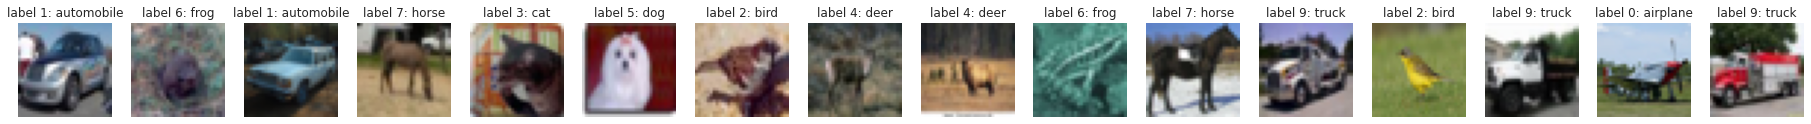

In [ ]:
N = 16
image, labels = zip(*random.sample(list(trainset), N))
fig, axes = plt.subplots(1, N, figsize=(2*N, 2))
for i, ax in enumerate(axes.ravel()):
  img = imshow(image[i], dataset_mean, dataset_std)
  ax.set_title("label {}: {}".format(labels[i],trainset.dataset.classes[labels[i]]))
  ax.axis('off')
  try:
    ax.imshow(img)
  except TypeError:
    print(type(img))


## Training, evaluation and plotting functions from Exercise 1

Here, we provide examples of the functions you implemented on the first exercise sheet to you. Some parts are still missing. You can ignore that for the time being, as you will implement that later as soon as the according functionality is required.

In [ ]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                break
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    if extra_pt_label != None and extra_pt != None:
      legend.append(extra_pt_label)
    
    if extra_pt:
        plt.vlines(np.argwhere(np.array(val_results) ==  extra_pt)[-1] + 1, 0, extra_pt, label=extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs


In [ ]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels, num_classes, 
                 num_hidden_units=30, num_hidden_layers=1, act_fn=None):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        nn.Module.__init__(self)
        self.input_size = img_width * img_width * num_in_channels
        self.output_size = num_classes

        if act_fn == None:
          self.act_fn = torch.nn.ReLU()
        else:
          self.act_fn = act_fn

        self.input_layer = torch.nn.Linear(self.input_size, num_hidden_units)

        self.layer = nn.ModuleList([torch.nn.Linear(num_hidden_units, num_hidden_units) for i in range(num_hidden_layers - 1)])

        self.output_layer = torch.nn.Linear(num_hidden_units, num_classes)

        
        self.output_act = torch.nn.Softmax()

    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        x = self.input_layer(torch.flatten(x, start_dim=1, end_dim=-1))
        x = self.act_fn(x)
        for layer in self.layer:
          x = layer(x)
          x = self.act_fn(x)

        x = self.output_layer(x)
        return self.output_act(x)


## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we do not use SGD as in exercise 1, but the commonly used Adam optimizer, since it behaves very robustly and is easy to use.

#### TODO
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.


In [ ]:
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=2)
print(model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 113 seconds.


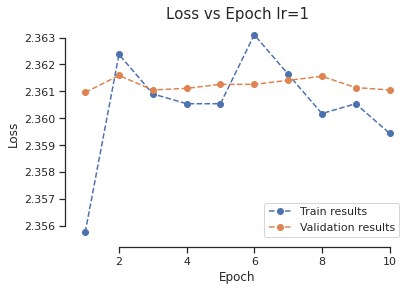

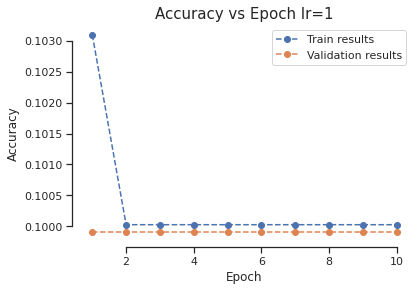

In [ ]:
lr = 1

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 10
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=None, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label="saved_point")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 113 seconds.


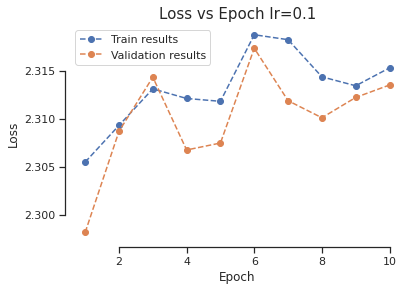

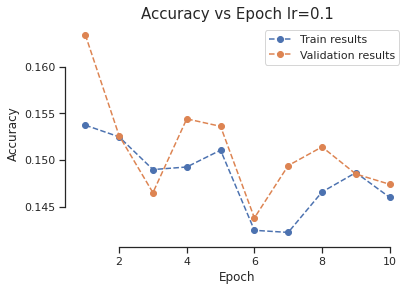

In [ ]:
lr = 0.1

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 10
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=None, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label="saved_point")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 117 seconds.


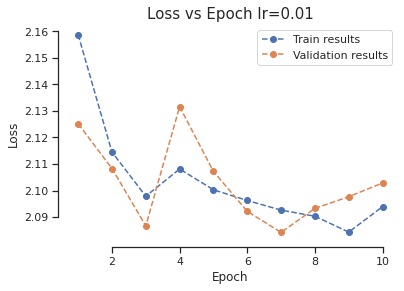

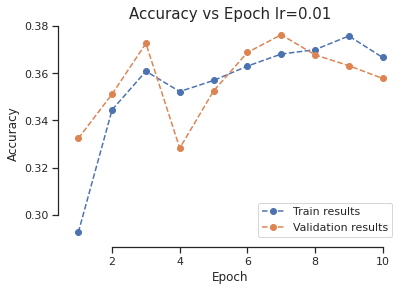

In [ ]:
lr = 0.01

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 10
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=None, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label="saved_point")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 113 seconds.


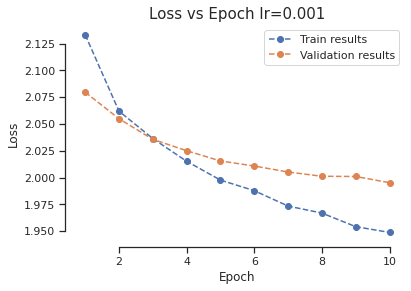

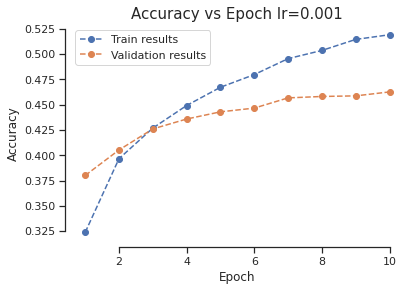

In [ ]:
lr = 0.001

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 10
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=None, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label="saved_point")

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

In [ ]:
lr = 0.001

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=None, verbose=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 1164 seconds.


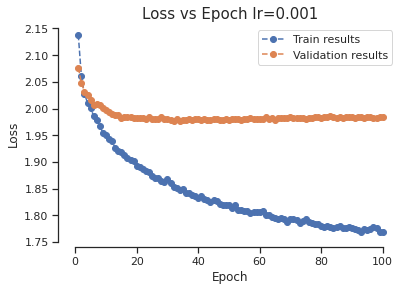

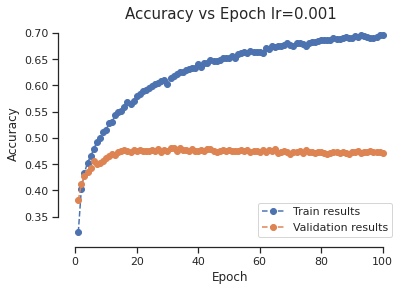

max val_accuracy: 0.4812 at epoch: 31
max val_loss: 1.9774832367897033 at epoch: 33


In [ ]:
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label="saved_point")
print(f"max val_accuracy: {max(val_accs)} at epoch: {np.argmax(val_accs)}")
print(f"min val_loss: {min(val_losses)} at epoch: {np.argmin(val_losses)}")

Let's have a look at those training curves! Here are some questions for you.

**Observations

**Training loss decreases but there are little fluctuations in my case but one can safely assume the trend to be decreasing. We have a decreasing trend because our model is learning. The cause of fluctuations is batch size and learning rate (which is hight at times due to adaptive nature)**


**The validation loss decreases because the model learns to generalize on the training set until it overfits. Fluctuations are expected for validation as slight change in parameters alters the prediction and it is an unseen data so after each epoch even though general trend on the validation set is of decreasing loss but we still see fluctuations.**

**Training accuracy has an increasing trend with slight fluctuations (explained in 1) but one can safely assume training accuracy to increase because with each epoch our model is able to memorize the training data better, however, same is not true for validation accuracy. Validation accuracy increases till a certain epoch (with slight fluctuations explained in 2) but then it decreases. This is because of overfitting**

**They are not. Epoch 31 for acc vs 33 for loss.**


**It was the best at Epoch 31 when the val acc was the highest. The acc of the train set is higher than the acc of the val set because it is trained on it. Despite that i wouldnt pick a model at a later epoch because the more you train the less it generalizes and it just keeps memorizing the training samples**


## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [ ]:
if not os.path.exists('check_point'):
  os.makedirs('check_point')
loss_function = torch.nn.CrossEntropyLoss()

model_path = pathlib.Path('check_point/model')
torch.save(model.state_dict(), model_path)
print(validate(valloader, model, loss_function, device, master_bar=None)[0])

model2 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
model2 = model2.to(device)
print(validate(valloader, model2, loss_function, device, master_bar=None)[0])


model2.load_state_dict(torch.load(model_path))
model2 = model2.to(device)
print(validate(valloader, model2, loss_function, device, master_bar=None)[0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1.985415756702423


2.3028603315353395


1.9847812891006469


## Early stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [ ]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, patience=0, verbose=False, path='checkpoint'):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
        """
        self.path = path
        self.counter = 0
        self.last_best_value = None
        self.patience = patience

    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        if self.counter > self.patience:
          return True
        else:
          return False

    def update(self, value, model):
        if self.last_best_value is None:
          self.last_best_value = value
        elif self.last_best_value < value:
            self.last_best_value = value
            self.counter = 0
            self.save_model(model)
        else:
          self.counter += 1

    def load_model(self, model):
      if os.path.exists(self.path + f'/model_{self.last_best_value}'):
        model.load_state_dict(torch.load(self.path + f'/model_{self.last_best_value}'))
      return model

    def save_model(self, model):
      if not os.path.exists(self.path):
        os.makedirs(self.path)
      torch.save(model.state_dict(), self.path + f'/model_{self.last_best_value}')

#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [ ]:
lr = 1e-3

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
early_stop = EarlyStopper(patience=0)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)



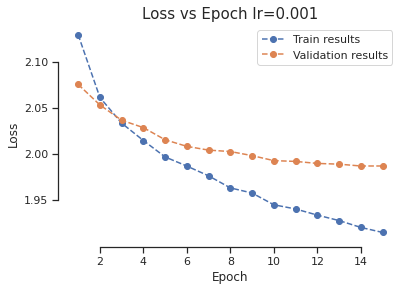

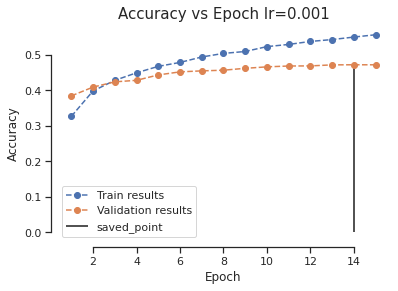

0.472


In [ ]:
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")
print(early_stop.last_best_value)

#### TODO
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?

**It didnt reach the best performance, because it stopped too early**

- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

**With of patience of 5 I reached the best validation accuracy.**

In [ ]:
lr = 1e-3

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)


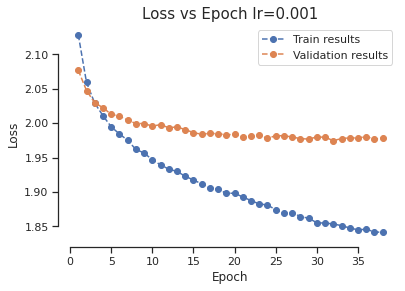

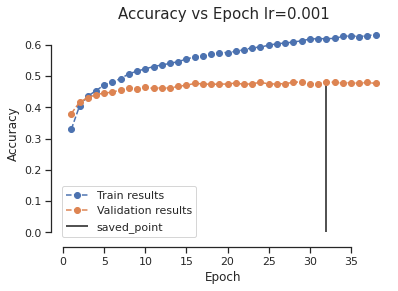

0.4826


In [ ]:
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")
print(early_stop.last_best_value)

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

**the training with a lr=1e-4 instead of lr=1e-3 takes much longer and the results are roughly the same 0.4808 vs 0.4813**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 389 seconds.


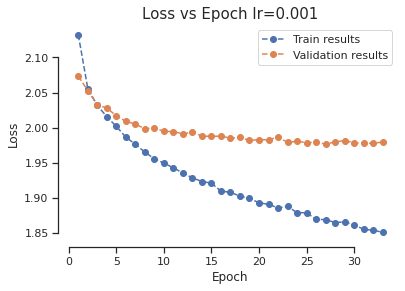

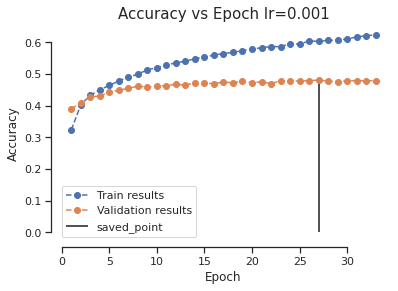

0.4808


In [ ]:
lr = 1e-3

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")
print(early_stop.last_best_value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 1030 seconds.


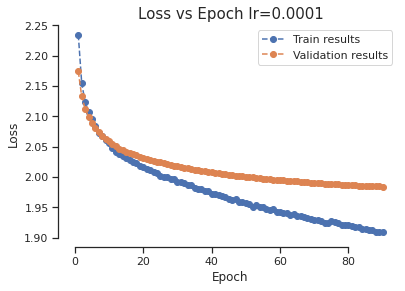

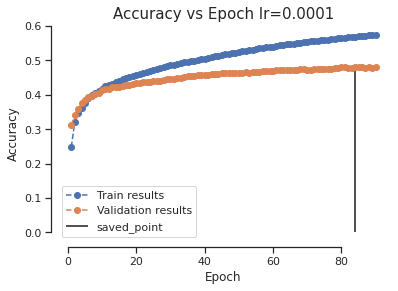

0.4813


In [ ]:
lr = 1e-4

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 60)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")
print(early_stop.last_best_value)

# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers
- activation function used

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 313 seconds.


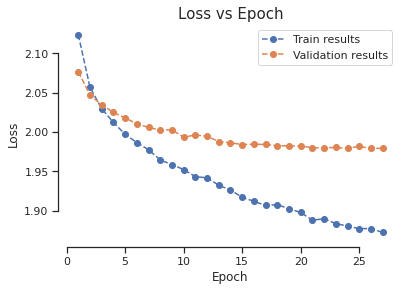

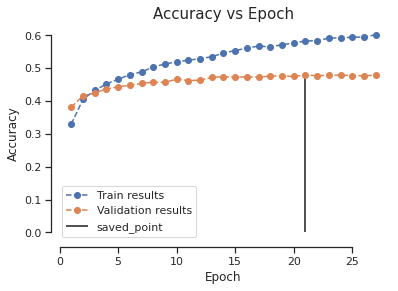

0.4793


In [ ]:
##base  acc 0.4793
lr = 1e-3

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units=60)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)
plot(f"Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")

print(early_stop.last_best_value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 283 seconds.


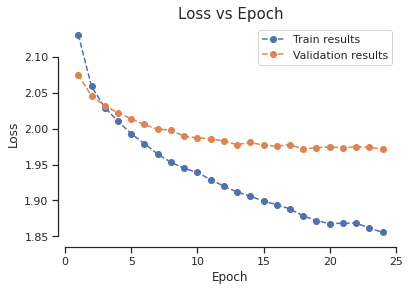

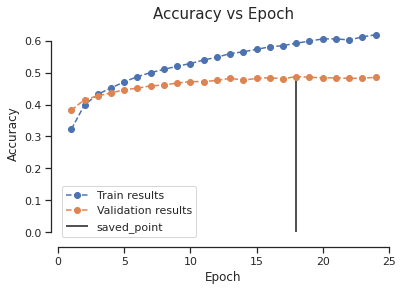

0.4875


In [ ]:
# nr_units: 60 -> 90, acc: 0.4793 ->0.4875
lr = 1e-3
num_hidden_units = 90
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units=num_hidden_units)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)
plot(f"Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")

print(early_stop.last_best_value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 501 seconds.


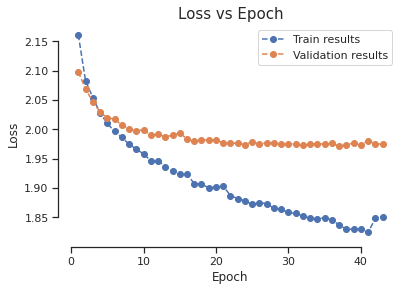

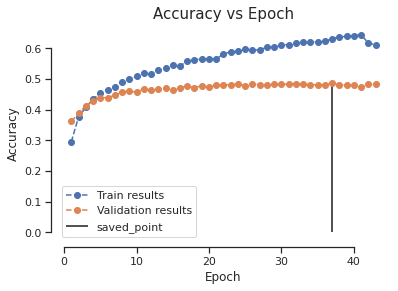

0.4871


In [ ]:
# nr_layers 1->2, acc: 0.4793 -> 0.4871
lr = 1e-3
num_hidden_layers = 2
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=num_hidden_layers, num_hidden_units=60)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)
plot(f"Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")
print(early_stop.last_best_value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 466 seconds.


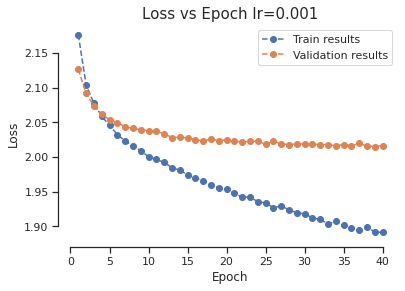

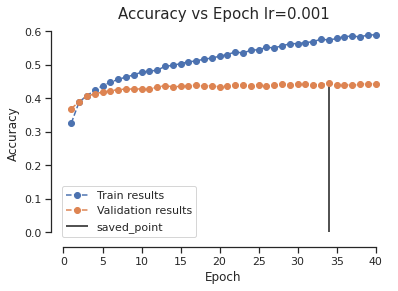

0.4447


In [ ]:
# act_func ReLU->Tanh, acc: 0.4793 -> 0.4447
lr = 1e-3
act_func = nn.Tanh()
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units=60, act_fn=act_func)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")
print(early_stop.last_best_value)

#### Remarks

**i got a val acc of 0.4875**

**changing the nr_units from 60 to 90 made the biggest difference**

**Not really, you are just adding more parameters to your model and overfitting it, not necessarily generalizing it. It's like fitting few data points with a polynomial of degree n, larger n you choose better you fit the test data but that doesn't necessarily mean it's a generalization**



#### TODO
- If we choose our best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?

**yes because there is some sort of dependency between nr_layer and nr_units. if you decrease the nr_layer you have to increase the nr_units to keep up and vice versa**

- Vary all of the parameters at the same time to maximize the predictive performance of your model. How to get it?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

In [ ]:
!rm -r "checkpoint"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished training after 949 seconds.


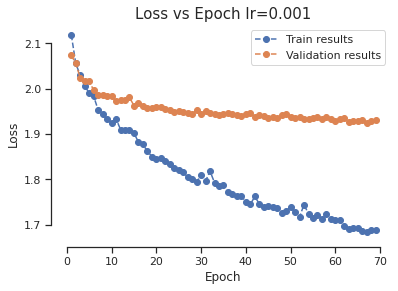

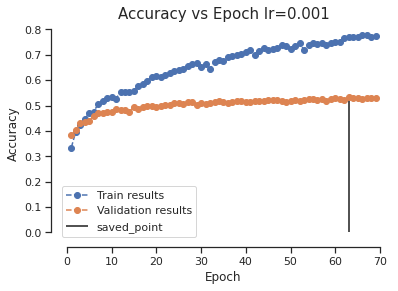

0.5338


In [ ]:
lr = 1e-3

# 1x 300 = 50,93

# 2x 350 = 53,01
# 2x 400 = 53,3 52,13 0.5338
# 2x 450 = 51,66

# 3x 80 = 49,44
# 3x 100 = 50,54
# 3x 200 = 51,1
# 3x 300 = 52,77
# 3x 350 = 51,87


# 4x 150 = 50,3
# 4x 200 = 51,62
# 4x 250 = 50,9
# 4x 300 = 48,8


# 2x 350 = 52,82 without softmax
# 1x 350 = 52,45 without softmax

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=2, num_hidden_units=350)
early_stop = EarlyStopper(patience=5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 100
model = model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stop, verbose=False)
plot(f"Loss vs Epoch lr={lr}", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch lr={lr}", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")

print(early_stop.last_best_value)
modle = early_stop.load_model(model)


#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?

**I would expect the performance would not be identical due to initialization. If we choose initialization to be same still the performance is not identical due to randomness in sampling the training data (in batches). Models are comparable because above factors would add to fluctuations only (in most casses) if trained for a large set of data.**

- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?

    - **If we fix random seed and due keep the initial weights same then I would expect performance to be identical**

    - The other could be to use a more sophisticated analysis. How?

    - **If we would repeat the measurement of calculating the accuracy and calculate a mean it should be comparable too**

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too! *(optional)*

In [ ]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1


    # Return the mean loss, the accuracy and the confusion matrix
    return accuracy(epoch_correct, epoch_total), confusion_matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Classification accuracy of test set: 	 0.53


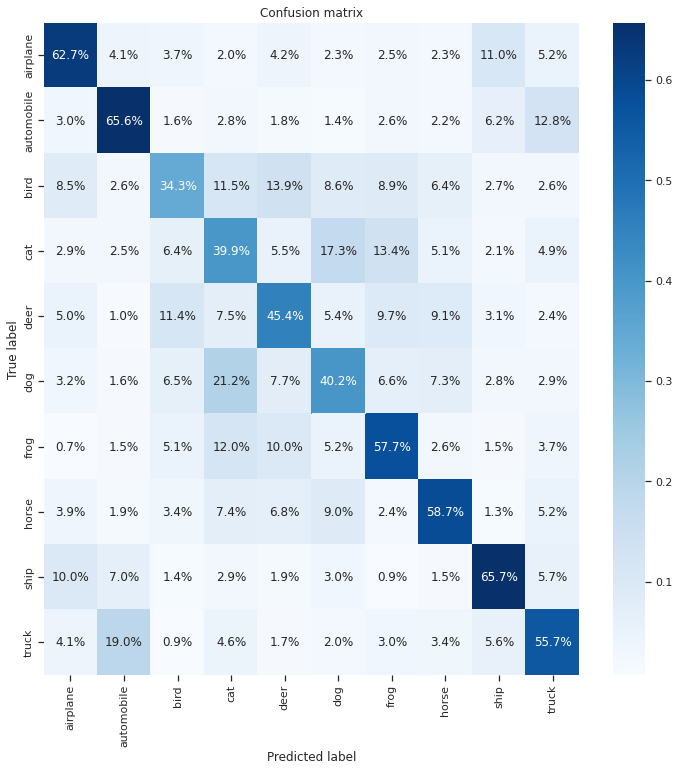

In [ ]:
t_accuracy, confusion_matrix = test(test_loader=testloader,model=model, device=device)
print(f'Classification accuracy of test set: \t {t_accuracy:.2f}')

# display confusion matrix
confusion_matrix_rowsum = torch.sum(confusion_matrix, dim=1)
confusion_matrix_std = torch.div(confusion_matrix.t(), confusion_matrix_rowsum).t()
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix_std, annot=True, cmap='Blues', fmt='.1%', yticklabels = list(trainset.dataset.classes), xticklabels=list(trainset.dataset.classes))
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Observations

- On the bird, cat, deer and dog class is the prediction poor
- Test accuracy is slightly lower.
- We are reduing the loss of the training set and not of the test set. So, the model might fit to the training data.
- When training the model you should never include the test data, becuase then you risk to overfit or customize your data accordingly.